## Project 2 - EDA - Iowa Liqour Sales Data and Des Moines Weather History

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import datetime 
import pickle
import seaborn as sns

%matplotlib inline

## PART 1: Collect Raw Weather Data for Polk County Using station in Des Moines from the NOAA 
URL:
https://www.ncdc.noaa.gov/cdo-web/search

In [5]:
#Import CSV files, pulled 5yrs of weather data for Des Moines
def get_weather_data(file_url):
    data = pd.read_csv(file_url, skiprows = 0)
    return data

dm_weather = get_weather_data('Des_Moines_Weather.csv')

In [6]:
dm_weather.tail(5)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
1909,USC00132209,"DES MOINES WSFO JOHNSTON, IA US",2019-03-30,0.12,0.0,0.0,43.0,29.0,NaN
1910,USC00132209,"DES MOINES WSFO JOHNSTON, IA US",2019-03-31,0.00,0.0,0.0,45.0,21.0,NaN
1911,USC00132209,"DES MOINES WSFO JOHNSTON, IA US",2019-04-01,0.00,0.0,0.0,61.0,33.0,NaN
1912,USC00132209,"DES MOINES WSFO JOHNSTON, IA US",2019-04-02,0.07,0.0,0.0,55.0,34.0,NaN
1913,USC00132209,"DES MOINES WSFO JOHNSTON, IA US",2019-04-03,0.00,0.0,0.0,NaN,NaN,35.0


In [7]:
dm_weather.columns

Index(['STATION', 'NAME', 'DATE', 'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN',
       'TOBS'],
      dtype='object')

In [8]:
#There are some missing values in SNOW, SNWD, TMAX, TMIN, TOBS
dm_weather.isnull().sum()

STATION     0
NAME        0
DATE        0
PRCP        0
SNOW        1
SNWD        6
TMAX        6
TMIN        8
TOBS       23
dtype: int64

In [9]:
# There appears to be NA fill them in with 0
dm_weather.loc[dm_weather['SNOW'].isnull()] = 0
mask = dm_weather.loc[dm_weather['SNWD'].isnull()] = 0

In [10]:
#find all TOBS (temperature at location) that is null but have max and min temperatures
#fill in the average of the max and min
mask = ((dm_weather["TOBS"].isnull()) & 
        (dm_weather["TMAX"].notna()) & 
        (dm_weather["TMIN"].notna()))

dm_weather.loc[mask, 'TOBS'] = (dm_weather.loc[mask, 'TMAX'] + dm_weather.loc[mask, 'TMIN'])/2

In [11]:
dm_weather.isnull().sum()

STATION    0
NAME       0
DATE       0
PRCP       0
SNOW       0
SNWD       0
TMAX       6
TMIN       8
TOBS       4
dtype: int64

In [12]:
#There are 4 TOBS with null value left
dm_weather.loc[dm_weather['TOBS'].isnull()]

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
62,USC00132209,"DES MOINES WSFO JOHNSTON, IA US",2014-03-04,0.0,0.0,3.0,31.0,NaN,NaN
1882,USC00132209,"DES MOINES WSFO JOHNSTON, IA US",2019-03-01,0.0,0.0,10.0,NaN,NaN,NaN
1895,USC00132209,"DES MOINES WSFO JOHNSTON, IA US",2019-03-16,0.0,0.0,0.0,NaN,NaN,NaN
1896,USC00132209,"DES MOINES WSFO JOHNSTON, IA US",2019-03-17,0.0,0.0,0.0,NaN,NaN,NaN


In [13]:
#fill forward for those 4 dates since they don't have both max or min temperatures
dm_weather['TOBS'].fillna(method='ffill', inplace=True)
dm_weather['TMAX'].fillna(method='ffill', inplace=True)
dm_weather['TMIN'].fillna(method='ffill', inplace=True)

In [14]:
dm_weather.isnull().sum()

STATION    0
NAME       0
DATE       0
PRCP       0
SNOW       0
SNWD       0
TMAX       0
TMIN       0
TOBS       0
dtype: int64

In [15]:
#Need to rename the column date so I can merge it
dm_weather = dm_weather.rename(columns={'DATE': 'Date'})

In [16]:
#Remove the name of the station
del dm_weather['NAME']
del dm_weather['STATION']

In [17]:
dm_weather.drop(dm_weather.tail(1).index,inplace=True)
dm_weather.tail()

,Date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS
1908,2019-03-29,0.00,0.0,0.0,49.0,36.0,42.5
1909,2019-03-30,0.12,0.0,0.0,43.0,29.0,36.0
1910,2019-03-31,0.00,0.0,0.0,45.0,21.0,33.0
1911,2019-04-01,0.00,0.0,0.0,61.0,33.0,47.0
1912,2019-04-02,0.07,0.0,0.0,55.0,34.0,44.5


In [18]:
#Create a new field called Fluc for daily temperature fluctuations
dm_weather['FLUC'] = dm_weather['TMAX'] - dm_weather['TMIN']

In [19]:
dm_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1913 entries, 0 to 1912
Data columns (total 8 columns):
Date    1913 non-null object
PRCP    1913 non-null float64
SNOW    1913 non-null float64
SNWD    1913 non-null float64
TMAX    1913 non-null float64
TMIN    1913 non-null float64
TOBS    1913 non-null float64
FLUC    1913 non-null float64
dtypes: float64(7), object(1)
memory usage: 134.5+ KB


In [20]:
#Create a new field called DIFF for daily change in temperature
dm_weather['DIFF'] = dm_weather.groupby(['Date'], as_index=False).sum()[['TOBS']].diff()

In [21]:
dm_weather.head()

,Date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,FLUC,DIFF
0,2014-01-01,0.1,1.5,4.0,9.0,3.0,4.0,6.0,NaN
1,2014-01-02,0.0,0.0,4.0,11.0,-8.0,-8.0,19.0,4.0
2,2014-01-03,0.0,0.0,4.0,33.0,-10.0,33.0,43.0,-12.0
3,2014-01-04,0.0,0.0,3.0,35.0,7.0,7.0,28.0,41.0
4,2014-01-05,0.0,0.0,3.0,8.0,-13.0,-13.0,21.0,-26.0


In [22]:
#Drop the row for the first date
dm_weather.dropna(subset=['DIFF'], axis=0, inplace=True)

In [23]:
dm_weather['Date'] = pd.to_datetime(dm_weather.Date, format="%Y-%m-%d")

In [24]:
#pickle the dm_weather dataframe as a checkpoint
with open('chal2_weather.pickle', 'wb') as to_write:
    pickle.dump(dm_weather, to_write)

## CHECKPOINT Weather dataframe cleaned

In [25]:
#Open the daylight webscrapped data
with open('chal2_webscrap.pickle','rb') as read_file:
    daylight = pickle.load(read_file)

In [26]:
#Check to make sure the columns are numeric and date is datetime
dm_weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1907 entries, 1 to 1907
Data columns (total 9 columns):
Date    1907 non-null datetime64[ns]
PRCP    1907 non-null float64
SNOW    1907 non-null float64
SNWD    1907 non-null float64
TMAX    1907 non-null float64
TMIN    1907 non-null float64
TOBS    1907 non-null float64
FLUC    1907 non-null float64
DIFF    1907 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 149.0 KB


## Create new dataframe to to merge weather and daylight dataframe

In [27]:
#Merge the daylight history with Des Moines weather dataframe
dm_clean = pd.merge(dm_weather, daylight, how='left', on='Date')

In [28]:
#Looks like we are missing a few Daylength rows
dm_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1907 entries, 0 to 1906
Data columns (total 10 columns):
Date         1907 non-null datetime64[ns]
PRCP         1907 non-null float64
SNOW         1907 non-null float64
SNWD         1907 non-null float64
TMAX         1907 non-null float64
TMIN         1907 non-null float64
TOBS         1907 non-null float64
FLUC         1907 non-null float64
DIFF         1907 non-null float64
Daylength    1901 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(8)
memory usage: 163.9 KB


In [29]:
#Let's fill forward for those 6 dates with no daylight data
dm_clean['Daylength'].fillna(method='ffill', inplace=True)

In [30]:
dm_clean.isnull().sum()

Date         0
PRCP         0
SNOW         0
SNWD         0
TMAX         0
TMIN         0
TOBS         0
FLUC         0
DIFF         0
Daylength    0
dtype: int64

In [31]:
dm_clean.head()

,Date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,FLUC,DIFF,Daylength
0,2014-01-02,0.0,0.0,4.0,11.0,-8.0,-8.0,19.0,4.0,1900-01-01 09:14:16
1,2014-01-03,0.0,0.0,4.0,33.0,-10.0,33.0,43.0,-12.0,1900-01-01 09:15:10
2,2014-01-04,0.0,0.0,3.0,35.0,7.0,7.0,28.0,41.0,1900-01-01 09:16:08
3,2014-01-05,0.0,0.0,3.0,8.0,-13.0,-13.0,21.0,-26.0,1900-01-01 09:17:09
4,2014-01-06,0.0,0.0,3.0,-3.0,-15.0,-7.0,12.0,-20.0,1900-01-01 09:18:15


## Create a Holiday covariate for each day of the year

In [32]:
# dm_clean['Date_2']= dm_clean['Date'].dt.date
dm_clean['Holiday'] = 0

In [33]:
# !pip install holidays
from datetime import date 
import holidays 

#get us holidays
us_holiday = holidays.US()

#If it is a holidays then it returns True else False 
for i in dm_clean.index:
    dm_clean.at[i, 'Holiday'] = 1 if dm_clean.loc[i,'Date'] in us_holiday else 0

In [34]:
dm_clean.drop(dm_clean[dm_clean['Date']=='1970-01-01'].index, inplace=True)

In [35]:
for i in dm_clean.index:
    if dm_clean.loc[i,'Holiday'] == 1 and i > 2:
        dm_clean.loc[i-1, 'Holiday'] = 1
        dm_clean.loc[i-2, 'Holiday'] = 1

In [36]:
dm_clean[dm_clean['Holiday']==1].tail(10)

,Date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,FLUC,DIFF,Daylength,Holiday
1815,2018-12-25,0.00,0.0,0.0,44.0,30.0,30.0,14.0,16.0,1900-01-01 09:09:26,1
1820,2018-12-30,0.00,0.0,0.0,42.0,17.0,33.0,25.0,-1.0,1900-01-01 09:11:50,1
1821,2018-12-31,0.05,0.0,0.0,34.0,20.0,20.0,14.0,0.0,1900-01-01 09:12:31,1
1822,2019-01-01,0.00,0.0,0.0,20.0,10.0,15.0,10.0,10.0,1900-01-01 09:13:16,1
1840,2019-01-19,0.00,0.0,5.0,16.0,1.0,1.0,15.0,-16.0,1900-01-01 09:37:14,1
1841,2019-01-20,0.03,0.8,5.0,9.0,1.0,3.0,8.0,4.0,1900-01-01 09:39:05,1
1842,2019-01-21,0.00,0.0,4.0,19.0,3.0,19.0,16.0,7.0,1900-01-01 09:40:57,1
1868,2019-02-16,0.25,3.5,9.0,21.0,-2.0,21.0,23.0,0.0,1900-01-01 10:41:33,1
1869,2019-02-17,0.32,7.0,14.0,26.0,20.0,20.0,6.0,14.0,1900-01-01 10:44:11,1
1870,2019-02-18,0.00,0.1,12.0,20.0,0.0,0.0,20.0,-6.0,1900-01-01 10:46:51,1


In [37]:
dm_clean['NEXT_TOBS'] = dm_clean.groupby(['Date'], as_index=False).first()[['TOBS']].shift(-1)
dm_clean['NEXT_PRCP'] = dm_clean.groupby(['Date'], as_index=False).first()[['PRCP']].shift(-1)
dm_clean['NEXT_SNOW'] = dm_clean.groupby(['Date'], as_index=False).first()[['SNOW']].shift(-1)

In [38]:
dm_clean.head(5)

,Date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,FLUC,DIFF,Daylength,Holiday,NEXT_TOBS,NEXT_PRCP,NEXT_SNOW
0,2014-01-02,0.0,0.0,4.0,11.0,-8.0,-8.0,19.0,4.0,1900-01-01 09:14:16,0,33.0,0.0,0.0
1,2014-01-03,0.0,0.0,4.0,33.0,-10.0,33.0,43.0,-12.0,1900-01-01 09:15:10,0,7.0,0.0,0.0
2,2014-01-04,0.0,0.0,3.0,35.0,7.0,7.0,28.0,41.0,1900-01-01 09:16:08,0,-13.0,0.0,0.0
3,2014-01-05,0.0,0.0,3.0,8.0,-13.0,-13.0,21.0,-26.0,1900-01-01 09:17:09,0,-7.0,0.0,0.0
4,2014-01-06,0.0,0.0,3.0,-3.0,-15.0,-7.0,12.0,-20.0,1900-01-01 09:18:15,0,4.0,0.0,0.0


In [39]:
#pickle the combined dataframe dm_clean
with open('chal2_weather_clean.pickle', 'wb') as to_write:
    pickle.dump(dm_clean, to_write)

## CHECKPOINT: Cleaned and combined weather data

In [40]:
with open('chal2_weather_clean.pickle','rb') as read_file:
    dm_clean = pickle.load(read_file)

In [41]:
dm_clean.head(2)

,Date,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,FLUC,DIFF,Daylength,Holiday,NEXT_TOBS,NEXT_PRCP,NEXT_SNOW
0,2014-01-02,0.0,0.0,4.0,11.0,-8.0,-8.0,19.0,4.0,1900-01-01 09:14:16,0,33.0,0.0,0.0
1,2014-01-03,0.0,0.0,4.0,33.0,-10.0,33.0,43.0,-12.0,1900-01-01 09:15:10,0,7.0,0.0,0.0


## PART 2: Import and Data Clean Iowa Liquor Sales Data into a Dataframe
URL: https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy

This dataset contains the spirits purchase information of Iowa Class “E” liquor licensees by product and date of purchase from January 1, 2012 to current. The dataset can be used to analyze total spirits sales in Iowa of individual products at the store level.

Column Name |Description Type   |Data type
------------|----------------------|----------
Invoice/Item Number|Concatenated invoice and line number associated with the liquor order |Plain Text
Date|Date of order|Date & Time
Store Number|Unique number assigned to the store who ordered the liquor|Plain Text
Store Name|Name of store who ordered the liquor|Plain Text
Address|Address of store who ordered the liquor|Plain Text
City|City where the store who ordered the liquor is located|Plain Text
County Number|Iowa county number for the county where store who ordered the liquor is located|Plain Text
County|County where the store who ordered the liquor is located|Plain Text
Category|Category code associated with the liquor ordered|Plain Text
Category Name|Category of the liquor ordered|Plain Text
Vendor Number|The vendor number of the company for the brand of liquor ordered|Plain Text
Vendor Name|The vendor name of the company for the brand of liquor ordered|Plain Text
Item Number|Item number for the individual liquor product ordered.|Plain Text
Item Description|Description of the individual liquor product ordered.|Plain Text
Pack|The number of bottles in a case for the liquor ordered|Number
Bottle Volume (ml)|Volume of each liquor bottle ordered in milliliters.|Number
State Bottle Cost|The amount that Alcoholic Beverages Division paid for each bottle of liquor ordered|Number
State Bottle Retail|The amount the store paid for each bottle of liquor ordered|Number
Bottles Sold|The number of bottles of liquor ordered by the store|Number
Sale (Dollars)|Total cost of liquor order (number of bottles multiplied by the state bottle retail)|Number
Volume Sold (Liters)|Total volume of liquor ordered in liters. (i.e. (Bottle Volume (ml) x Bottles Sold)/1,000)|Number
Volume Sold (Gallons)|Total volume of liquor ordered in gallons. (i.e. (Bottle Volume (ml) x Bottles Sold)/3785.411784)|Number

In [44]:
#Import CSV file for Iowa Liquor Sales
def get_liquor_data(file_url):
    data = pd.read_csv(file_url, skiprows = 0)
    return data

liquor_data = get_liquor_data('Iowa_Liquor_Sales.csv')

/Users/robfang29/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (6,14) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [45]:
liquor_data.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Iowa ZIP Code Tabulation Areas,Iowa Watershed Sub-Basins (HUC 08),Iowa Watersheds (HUC 10),County Boundaries of Iowa,US Counties
0,S25388100011,04/30/2015,2626,Hy-Vee Drugstore / University / DSM,4100 UNIVERSITY AVE,DES MOINES,50311,4100 UNIVERSITY AVE\nDES MOINES 50311\n(41.600...,77.0,Polk,...,4.83,24,115.92,9.0,2.38,773.0,25.0,316.0,64.0,1878.0
1,S13455400008,07/22/2013,4619,Smokin' Joe's #3 Tobacco and Liquor,1737 AVE H,FORT MADISON,52627,"1737 AVE H\nFORT MADISON 52627\n(40.63021, -91...",56.0,Lee,...,10.70,6,64.20,10.5,2.77,803.0,10.0,120.0,99.0,1827.0
2,S28087500016,09/23/2015,3987,Wine and Spirits Shoppe Of,111 S PHILLIPS ST,ALGONA,50511,"111 S PHILLIPS ST\nALGONA 50511\n(43.06882, -9...",55.0,Kossuth,...,18.74,6,112.44,4.5,1.19,540.0,24.0,165.0,6.0,1794.0
3,S13433300005,07/18/2013,4370,Kum & Go #240 / North Ave Norwalk,530 NORTH AVE,NORWALK,50211,"530 NORTH AVE\nNORWALK 50211\n(41.475381, -93....",91.0,Warren,...,13.46,12,161.52,9.0,2.38,197.0,29.0,345.0,74.0,1886.0
4,S10087100018,01/16/2013,3789,Wal-Mart 1393 / Oskaloosa,2203 A AVENUE WEST,OSKALOOSA,52577,2203 A AVENUE WEST\nOSKALOOSA 52577\n(41.29851...,62.0,Mahaska,...,15.48,12,185.76,9.0,2.38,914.0,30.0,360.0,76.0,290.0


In [46]:
#Column looks pretty clean
liquor_data.columns

Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)',
       'Iowa ZIP Code Tabulation Areas', 'Iowa Watershed Sub-Basins (HUC 08)',
       'Iowa Watersheds (HUC 10)', 'County Boundaries of Iowa', 'US Counties'],
      dtype='object')

In [364]:
#15mm records! Filter the data down so it is more workable
liquor_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15888209 entries, 0 to 15888208
Data columns (total 29 columns):
Invoice/Item Number                   object
Date                                  object
Store Number                          int64
Store Name                            object
Address                               object
City                                  object
Zip Code                              object
Store Location                        object
County Number                         float64
County                                object
Category                              float64
Category Name                         object
Vendor Number                         float64
Vendor Name                           object
Item Number                           object
Item Description                      object
Pack                                  int64
Bottle Volume (ml)                    int64
State Bottle Cost                     float64
State Bottle Retail          

In [47]:
liquor_data.County.value_counts().sort_values(ascending=False).head(5)

Polk          1894517
POLK           984940
Linn           831124
Scott          622964
Black Hawk     546269
Name: County, dtype: int64

In [48]:
#top county is Polk but there is naming discrepancy, convert it all to lower case
liquor_data['County'] = liquor_data.County.str.lower()

In [49]:
liquor_data.County.value_counts().sort_values(ascending=False).head(5)

polk          2879457
linn          1311133
scott          978175
black hawk     878502
johnson        797383
Name: County, dtype: int64

In [3]:
#Focus on Polk County for the analysis, 2.88mm records should be sufficient for my purposes
liquor_polk = liquor_data[liquor_data['County'] == 'polk']

NameError: name 'liquor_data' is not defined

In [51]:
liquor_polk.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Iowa ZIP Code Tabulation Areas,Iowa Watershed Sub-Basins (HUC 08),Iowa Watersheds (HUC 10),County Boundaries of Iowa,US Counties
0,S25388100011,04/30/2015,2626,Hy-Vee Drugstore / University / DSM,4100 UNIVERSITY AVE,DES MOINES,50311,4100 UNIVERSITY AVE\nDES MOINES 50311\n(41.600...,77.0,polk,...,4.83,24,115.92,9.00,2.38,773.0,25.0,316.0,64.0,1878.0
5,S20241200042,07/23/2014,4062,H and A Mini Mart Corp,145 UNIVERSITY AVE,DES MOINES,50314,145 UNIVERSITY AVE\nDES MOINES 50314\n(41.6004...,77.0,polk,...,13.13,1,13.13,0.75,0.20,432.0,25.0,316.0,64.0,1878.0
8,S17629600004,02/27/2014,2953,Dahl's / E. Euclid,1320 E. EUCLID,DES MOINES,50316,"1320 E. EUCLID\nDES MOINES 50316\n(41.627783, ...",77.0,polk,...,9.74,12,116.88,9.00,2.38,778.0,29.0,342.0,64.0,1878.0
13,S29047200042,11/12/2015,2854,CVS / Pharmacy #10480 / Urbandale,14201 HICKMAN RD,URBANDALE,50323,"14201 HICKMAN RD\nURBANDALE 50323\n(41.614963,...",77.0,polk,...,21.57,3,64.71,2.25,0.59,7.0,27.0,332.0,62.0,1878.0
15,S14425800029,09/09/2013,2521,Hy-Vee Food and Drug / Grand / WDM,1990 GRAND AVENUE,WEST DES MOINES,50265,1990 GRAND AVENUE\nWEST DES MOINES 50265\n(41....,77.0,polk,...,32.66,6,195.96,6.00,1.59,579.0,27.0,333.0,64.0,1878.0


### Data pickled but commented out to prevent overwriting

In [52]:
#pickle the polk_county_subset
#with open('polk_subset.pickle', 'wb') as to_write:
#pickle.dump(liquor_polk, to_write)

## CHECKPOINT Polk County Subset - Data Cleaning

In [42]:
with open('polk_subset.pickle','rb') as read_file:
    liquor_polk = pickle.load(read_file)

In [43]:
#Convert Liquor Date field to dt datetime
liquor_polk['Date'] = pd.to_datetime(liquor_polk.Date, format="%m/%d/%Y")

In [44]:
liquor_polk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2879457 entries, 0 to 15888206
Data columns (total 29 columns):
Invoice/Item Number                   object
Date                                  datetime64[ns]
Store Number                          int64
Store Name                            object
Address                               object
City                                  object
Zip Code                              object
Store Location                        object
County Number                         float64
County                                object
Category                              float64
Category Name                         object
Vendor Number                         float64
Vendor Name                           object
Item Number                           object
Item Description                      object
Pack                                  int64
Bottle Volume (ml)                    int64
State Bottle Cost                     float64
State Bottle Retail   

In [45]:
#Lets drop some columns that are unnecessary since we narrowed it to Polk County
liquor_polk = liquor_polk.drop(['Iowa ZIP Code Tabulation Areas', 'Iowa Watershed Sub-Basins (HUC 08)',
       'Iowa Watersheds (HUC 10)', 'County Boundaries of Iowa', 'US Counties'], axis=1, errors="ignore")

In [46]:
liquor_polk.iloc[0]

Invoice/Item Number                                           S25388100011
Date                                                   2015-04-30 00:00:00
Store Number                                                          2626
Store Name                             Hy-Vee Drugstore / University / DSM
Address                                                4100 UNIVERSITY AVE
City                                                            DES MOINES
Zip Code                                                             50311
Store Location           4100 UNIVERSITY AVE\nDES MOINES 50311\n(41.600...
County Number                                                           77
County                                                                polk
Category                                                       1.05101e+06
Category Name                                      AMERICAN GRAPE BRANDIES
Vendor Number                                                          205
Vendor Name              

In [47]:
#List the most popular brands in polk county
top10_sales = pd.DataFrame(liquor_polk['Item Description'].value_counts().sort_values(ascending=False).head(10))
top10_sales

,Item Description
Hawkeye Vodka,72600
Black Velvet,66666
Fireball Cinnamon Whiskey,35766
Jim Beam,29781
Seagrams 7 Crown Bl Whiskey,28284
Captain Morgan Spiced Rum,27315
Mccormick Vodka Pet,26255
Absolut Swedish Vodka 80 Prf,26210
Bacardi Superior Rum,26098
Smirnoff Vodka 80 Prf,25806


Text(0.5, 0, 'Liquor Brands')

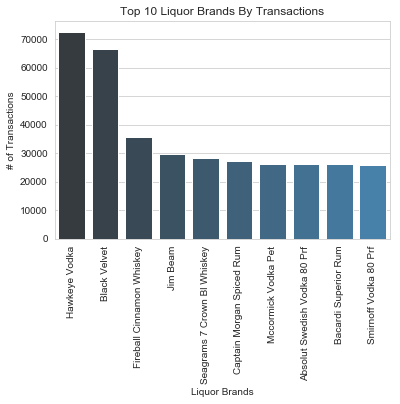

In [48]:
x = top10_sales.index
sns.set_style("whitegrid")
sns.set_palette("Blues_d", n_colors=20)
sns.barplot(x, y='Item Description', data=top10_sales);
plt.ylabel('# of Transactions')
plt.title('Top 10 Liquor Brands By Transactions')
plt.xticks(rotation=90)
plt.xlabel("Liquor Brands")

In [52]:
liquor_polk['Category Name'] = liquor_polk['Category Name'].str.upper()

In [53]:
#List the top 10 categories
top10_categories = pd.DataFrame(liquor_polk['Category Name'].value_counts().sort_values(ascending=False).head(10))
top10_categories

,Category Name
VODKA 80 PROOF,242330
CANADIAN WHISKIES,230660
AMERICAN VODKAS,178183
STRAIGHT BOURBON WHISKIES,171550
SPICED RUM,134187
WHISKEY LIQUEUR,116958
VODKA FLAVORED,102291
BLENDED WHISKIES,96753
TEQUILA,87938
IMPORTED VODKA,85971


Text(0.5, 0, 'Liquor Type')

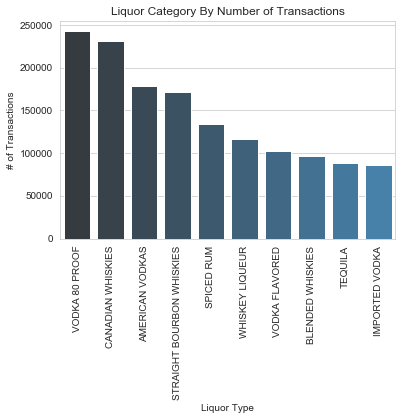

In [54]:
x = top10_categories.index
sns.barplot(x, y='Category Name', data=top10_categories);
plt.ylabel('# of Transactions')
plt.title('Liquor Category By Number of Transactions')
plt.xticks(rotation=90)
plt.xlabel("Liquor Type")

In [55]:
#Check to see if there are any null values
liquor_polk['Category Name'].isnull().sum()

4688

In [56]:
#Fill them as OTHERS
liquor_polk['Category Name'].fillna("OTHERS", inplace=True)

In [57]:
#Create a function that breaks out the type of liquor from Category Name
def liquor_type(name):
    if 'WHISKIES' in name:
        return 'WHISKIES'
    elif 'VODKA'in name:
        return 'VODKA'
    elif 'RUM' in name:
        return 'RUM'
    elif 'GINS' in name:
        return 'GINS'
    elif 'TEQUILA' in name:
        return 'TEQUILA'
    elif 'BRANDIES' in name:
        return 'BRANDIES'
    elif 'SCHNAPPS' in name:
        return 'SCHNAPPS'
    elif 'COFFEE LIQUEURS'in name:
        return 'COFFEE LIQUEURS'
    elif 'CREAM LIQUEURS'in name:
        return 'COFFEE LIQUEURS'
    elif 'LIQUEURS'in name:
        return 'LIQUEURS'
    elif 'SCOTCH' in name:
        return 'SCOTCH'
    elif 'COCKTAILS'in name:
        return 'COCKTAILS'
    else:
        return "OTHERS"

In [58]:
liquor_polk['Liquor Type'] = liquor_polk['Category Name'].apply(liquor_type)

In [59]:
liquor_polk.head(5)

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,...,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Liquor Type
0,S25388100011,2015-04-30,2626,Hy-Vee Drugstore / University / DSM,4100 UNIVERSITY AVE,DES MOINES,50311,4100 UNIVERSITY AVE\nDES MOINES 50311\n(41.600...,77.0,polk,...,E & J Vs Brandy,24,375,3.22,4.83,24,115.92,9.00,2.38,BRANDIES
5,S20241200042,2014-07-23,4062,H and A Mini Mart Corp,145 UNIVERSITY AVE,DES MOINES,50314,145 UNIVERSITY AVE\nDES MOINES 50314\n(41.6004...,77.0,polk,...,Everclear Alcohol,12,750,8.75,13.13,1,13.13,0.75,0.20,OTHERS
8,S17629600004,2014-02-27,2953,Dahl's / E. Euclid,1320 E. EUCLID,DES MOINES,50316,"1320 E. EUCLID\nDES MOINES 50316\n(41.627783, ...",77.0,polk,...,Uv Ivory (vanilla) Vodka,12,750,6.50,9.74,12,116.88,9.00,2.38,VODKA
13,S29047200042,2015-11-12,2854,CVS / Pharmacy #10480 / Urbandale,14201 HICKMAN RD,URBANDALE,50323,"14201 HICKMAN RD\nURBANDALE 50323\n(41.614963,...",77.0,polk,...,Tullamore Dew Irish Whisky,12,750,14.38,21.57,3,64.71,2.25,0.59,WHISKIES
15,S14425800029,2013-09-09,2521,Hy-Vee Food and Drug / Grand / WDM,1990 GRAND AVENUE,WEST DES MOINES,50265,1990 GRAND AVENUE\nWEST DES MOINES 50265\n(41....,77.0,polk,...,Grey Goose Vodka,6,1000,21.77,32.66,6,195.96,6.00,1.59,VODKA


In [60]:
#pickle the polk_county_subset
with open('liquor_polk.pickle', 'wb') as to_write:
    pickle.dump(liquor_polk, to_write)

## CHECKPOINT - Dataframe Broken Out by Liquor Type

In [61]:

with open('liquor_polk.pickle','rb') as read_file:
    liquor_polk = pickle.load(read_file)

## Aggregate liquor data into daily and graph distributions

In [63]:
#Let's aggregate the data by Date
liquor_daily = liquor_polk.groupby('Date').agg(np.sum)

In [64]:
liquor_daily.head(2)

,Store Number,County Number,Category,Vendor Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
Date,,,,,,,,,,,,
2012-01-03,3271235,84238.0,1.143229e+09,285675.0,13720,936125,10123.25,15206.90,6566,79847.77,5519.81,1458.28
2012-01-04,5276217,130284.0,1.766513e+09,435257.0,20450,1515300,16030.14,24078.12,16752,205776.59,14746.59,3896.22


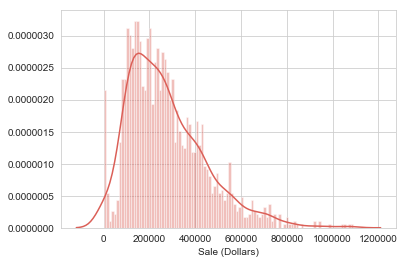

In [67]:
sns.distplot(liquor_daily["Sale (Dollars)"],bins=100);

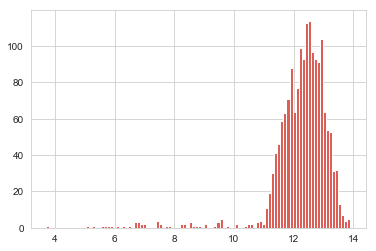

In [68]:
#log transform, neither one looks all that normal
liquor_daily["Sale (Dollars)"].apply(np.log).hist(bins=100)

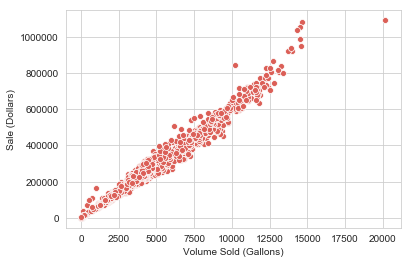

In [343]:
sns.scatterplot(x='Volume Sold (Gallons)', y="Sale (Dollars)", data=liquor_daily)

In [69]:
liquor_polk.size

71986425

## Create new Dataframe Groupyby Date, Store Number, Category Name, Liquor Type

In [70]:
polk_OLS = liquor_polk.groupby(['Date','Store Number','Category Name','Liquor Type'], as_index=False)['Pack', 
                                 'Bottle Volume (ml)',
                                 'State Bottle Cost', 
                                 'State Bottle Retail', 
                                 'Bottles Sold',
                                 'Sale (Dollars)',
                                 'Volume Sold (Gallons)'].sum()

In [71]:
polk_OLS.head()

,Date,Store Number,Category Name,Liquor Type,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Gallons)
0,2012-01-03,2190,100 PROOF VODKA,VODKA,6,1750,7.46,11.19,6,67.14,2.77
1,2012-01-03,2190,AMERICAN COCKTAILS,COCKTAILS,24,2000,8.70,13.06,24,156.72,6.34
2,2012-01-03,2190,AMERICAN DRY GINS,GINS,24,2000,8.19,12.27,24,147.24,6.34
3,2012-01-03,2190,AMERICAN GRAPE BRANDIES,BRANDIES,36,1375,9.99,14.98,36,234.60,5.55
4,2012-01-03,2190,BLENDED WHISKIES,WHISKIES,24,4500,29.27,44.16,15,184.32,4.55


In [72]:
polk_OLS.size

11091916

In [73]:
#Create a new column for retail margin
polk_OLS['Retail Margin'] = (polk_OLS['State Bottle Retail'] 
                             - polk_OLS['State Bottle Cost'])/polk_OLS['State Bottle Cost']

In [74]:
polk_OLS['Gross Margin'] = polk_OLS['Retail Margin'] * polk_OLS['Sale (Dollars)']

In [75]:
polk_OLS.head()

,Date,Store Number,Category Name,Liquor Type,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Gallons),Retail Margin,Gross Margin
0,2012-01-03,2190,100 PROOF VODKA,VODKA,6,1750,7.46,11.19,6,67.14,2.77,0.500000,33.570000
1,2012-01-03,2190,AMERICAN COCKTAILS,COCKTAILS,24,2000,8.70,13.06,24,156.72,6.34,0.501149,78.540138
2,2012-01-03,2190,AMERICAN DRY GINS,GINS,24,2000,8.19,12.27,24,147.24,6.34,0.498168,73.350330
3,2012-01-03,2190,AMERICAN GRAPE BRANDIES,BRANDIES,36,1375,9.99,14.98,36,234.60,5.55,0.499499,117.182583
4,2012-01-03,2190,BLENDED WHISKIES,WHISKIES,24,4500,29.27,44.16,15,184.32,4.55,0.508712,93.765794


In [76]:
#pickle the polk_OLS
with open('polk_OLS.pickle', 'wb') as to_write:
    pickle.dump(polk_OLS, to_write)

## CHECKPOINT - Segment out Liquor Types

In [77]:
with open('polk_OLS.pickle','rb') as read_file:
    polk_daily = pickle.load(read_file)

In [78]:
polk_daily.head()

,Date,Store Number,Category Name,Liquor Type,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Gallons),Retail Margin,Gross Margin
0,2012-01-03,2190,100 PROOF VODKA,VODKA,6,1750,7.46,11.19,6,67.14,2.77,0.500000,33.570000
1,2012-01-03,2190,AMERICAN COCKTAILS,COCKTAILS,24,2000,8.70,13.06,24,156.72,6.34,0.501149,78.540138
2,2012-01-03,2190,AMERICAN DRY GINS,GINS,24,2000,8.19,12.27,24,147.24,6.34,0.498168,73.350330
3,2012-01-03,2190,AMERICAN GRAPE BRANDIES,BRANDIES,36,1375,9.99,14.98,36,234.60,5.55,0.499499,117.182583
4,2012-01-03,2190,BLENDED WHISKIES,WHISKIES,24,4500,29.27,44.16,15,184.32,4.55,0.508712,93.765794


In [79]:
polk_daily = polk_daily.drop(['Category Name'], axis=1, errors="ignore")

In [80]:
#Create new categorical features from liquor type
polk_daily = pd.get_dummies(polk_daily)

In [82]:
#Change columns name back to just liquor names
liquor_list = ['WHISKIES','VODKA','RUM','GINS','TEQUILA','BRANDIES', 'COFFEE LIQUEURS',
               'LIQUEURS','SCOTCH','SCHNAPPS','COCKTAILS', 'OTHERS']
for liquor in liquor_list:
    col_name = "Liquor Type_" + liquor
    polk_daily.rename(index=str, columns={col_name: liquor},inplace=True)

In [83]:
polk_daily.head()

,Date,Store Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Gallons),Retail Margin,...,COFFEE LIQUEURS,GINS,LIQUEURS,OTHERS,RUM,SCHNAPPS,SCOTCH,TEQUILA,VODKA,WHISKIES
0,2012-01-03,2190,6,1750,7.46,11.19,6,67.14,2.77,0.500000,...,0,0,0,0,0,0,0,0,1,0
1,2012-01-03,2190,24,2000,8.70,13.06,24,156.72,6.34,0.501149,...,0,0,0,0,0,0,0,0,0,0
2,2012-01-03,2190,24,2000,8.19,12.27,24,147.24,6.34,0.498168,...,0,1,0,0,0,0,0,0,0,0
3,2012-01-03,2190,36,1375,9.99,14.98,36,234.60,5.55,0.499499,...,0,0,0,0,0,0,0,0,0,0
4,2012-01-03,2190,24,4500,29.27,44.16,15,184.32,4.55,0.508712,...,0,0,0,0,0,0,0,0,0,1


### Aggregate by Date and add more features

In [84]:
with open('chal2_polk_daily.pickle','rb') as read_file:
    polk_daily_OLS = pickle.load(read_file)

In [85]:
for liquor in liquor_list:
    polk_daily_OLS[liquor] = polk_daily_OLS[liquor] * polk_daily_OLS['Volume Sold (Gallons)']

In [86]:
polk_daily_OLS = polk_daily_OLS.groupby(['Date', 'Store Number'], as_index=False).agg(np.sum)

In [87]:
polk_daily_OLS.head()

,Date,Store Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Gallons),Retail Margin,...,COFFEE LIQUEURS,GINS,LIQUEURS,OTHERS,RUM,SCHNAPPS,SCOTCH,TEQUILA,VODKA,WHISKIES
0,2012-01-03,2190,996,84125,1152.84,1729.60,972,15922.40,236.99,14.006693,...,6.34,14.33,24.38,0.53,49.66,7.53,1.0,11.49,69.68,40.16
1,2012-01-03,2238,60,4750,56.00,83.98,11,188.12,2.84,1.997792,...,0.00,0.53,0.00,0.00,0.00,0.00,0.0,0.53,0.99,0.79
2,2012-01-03,2532,388,36850,288.64,433.95,391,4118.04,97.37,9.573471,...,0.00,2.38,4.76,2.38,13.87,5.45,0.0,8.52,36.23,13.09
3,2012-01-03,2534,1406,117950,1157.42,1738.80,662,8699.65,164.75,22.099077,...,11.26,5.73,2.57,7.72,19.00,12.46,0.0,3.96,41.82,33.62
4,2012-01-03,2548,306,29750,295.33,444.67,217,2966.20,54.84,9.095415,...,0.59,0.00,4.74,8.32,5.74,5.74,0.0,4.76,8.52,5.15


In [88]:
polk_daily_OLS.shape

(63658, 23)

In [95]:
#Create Date columns
polk_daily_OLS["Year"] = polk_daily_OLS.Date.dt.year
polk_daily_OLS["Month"] = polk_daily_OLS.Date.dt.month
polk_daily_OLS["Week"] = polk_daily_OLS.Date.dt.week
polk_daily_OLS["Day"] = polk_daily_OLS.Date.dt.day
polk_daily_OLS["Day_of_week"] = polk_daily_OLS.Date.dt.weekday
polk_daily_OLS["Qtr"] = polk_daily_OLS.Date.dt.quarter

In [96]:
polk_daily_OLS.head(2)

,Date,Store Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Gallons),Retail Margin,...,SCOTCH,TEQUILA,VODKA,WHISKIES,Year,Month,Week,Day,Day_of_week,Qtr
0,2012-01-03,2190,996,84125,1152.84,1729.60,972,15922.40,236.99,14.006693,...,1.0,11.49,69.68,40.16,2012,1,1,3,1,1
1,2012-01-03,2238,60,4750,56.00,83.98,11,188.12,2.84,1.997792,...,0.0,0.53,0.99,0.79,2012,1,1,3,1,1


In [97]:
#Narrow it down to the last 5 years
polk_daily_OLS = polk_daily_OLS[polk_daily_OLS['Year'] > 2013]

In [98]:
polk_daily_OLS.shape

(48025, 29)

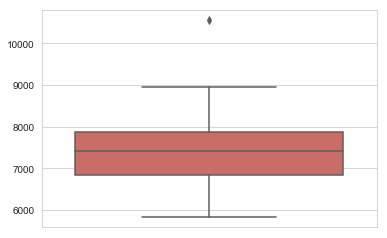

In [99]:
#Identify if there are outliers
df_sales = pd.DataFrame(polk_daily_OLS.groupby('Week')['Sale (Dollars)'].mean())
sns.boxplot(y=df_sales)

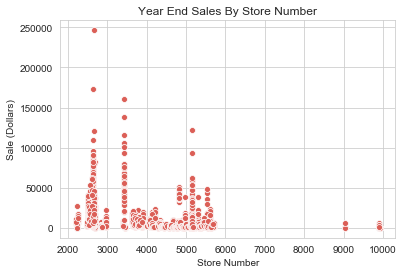

In [332]:
df_sales_store = pd.DataFrame(polk_daily_OLS.groupby(['Week','Store Number'],as_index=False)['Sale (Dollars)'].mean())
sns.scatterplot(x='Store Number', y="Sale (Dollars)", data=df_sales_store)
plt.title("Year End Sales By Store Number")

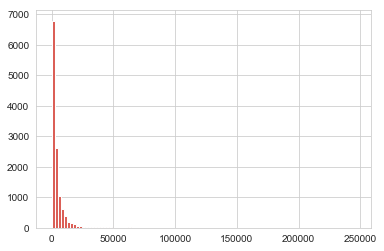

In [330]:
df_sales_store['Sale (Dollars)'].hist(bins=100);

### Merge the weather dataframe with polk liquor sales data by Date

In [102]:
polk_daily_clean = pd.merge(polk_daily_OLS, dm_clean, on='Date')

In [103]:
polk_daily_clean["Daylight_mins"] = polk_daily_clean['Daylength'].dt.hour*60+polk_daily_clean['Daylength'].dt.minute

In [106]:
polk_daily_clean.head()

,Date,Store Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Gallons),Retail Margin,...,TMIN,TOBS,FLUC,DIFF,Daylength,Holiday,NEXT_TOBS,NEXT_PRCP,NEXT_SNOW,Daylight_mins
0,2014-01-02,2190,648,47525,725.74,1088.63,256,5095.54,51.57,13.996297,...,-8.0,-8.0,19.0,4.0,1900-01-01 09:14:16,0,33.0,0.0,0.0,554
1,2014-01-02,2248,498,23150,363.10,544.63,221,3018.86,34.98,9.501286,...,-8.0,-8.0,19.0,4.0,1900-01-01 09:14:16,0,33.0,0.0,0.0,554
2,2014-01-02,2527,936,93950,826.96,1243.78,1192,14445.38,352.78,15.575936,...,-8.0,-8.0,19.0,4.0,1900-01-01 09:14:16,0,33.0,0.0,0.0,554
3,2014-01-02,2528,1386,92525,834.73,1258.14,1031,9829.36,202.42,15.132703,...,-8.0,-8.0,19.0,4.0,1900-01-01 09:14:16,0,33.0,0.0,0.0,554
4,2014-01-02,2561,918,65775,893.23,1342.93,1151,15489.88,394.45,17.741271,...,-8.0,-8.0,19.0,4.0,1900-01-01 09:14:16,0,33.0,0.0,0.0,554


## CHECKPOINT - Final Clean Liquor Data for Merging with Weather

In [256]:
#Pickle the combined dataframe as polk_clean
with open('chal2_polk_clean.pickle', 'wb') as to_write:
    pickle.dump(polk_daily_clean, to_write)

### Segment out Dependent Variable: Total Sale (Dollars) By Store Number

In [108]:
df_year_sales = polk_daily_clean.groupby(['Store Number', 'Year'], as_index=False)['Sale (Dollars)'].sum()

In [111]:
#Data Exploration on on Total Yearly Sales
sales_by_store = pd.DataFrame(df_year_sales.groupby(df_year_sales['Store Number'], as_index=False)['Sale (Dollars)'].mean())
sales_by_store.sort_values(by='Sale (Dollars)', ascending=False, inplace=True)
sales_by_store.head(10)

,Store Number,Sale (Dollars)
19,2633,8.906944e+06
170,4829,8.208127e+06
45,3420,1.995173e+06
22,2663,1.754228e+06
14,2619,1.564696e+06
212,5144,1.524817e+06
21,2648,1.445417e+06
4,2502,1.273941e+06
12,2561,1.250556e+06
0,2190,1.234593e+06


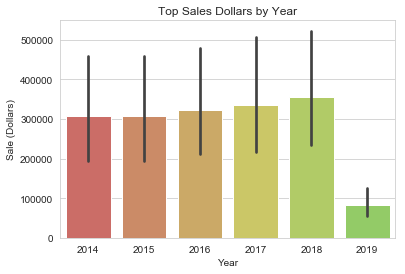

In [304]:
sns.barplot(x ='Year',y='Sale (Dollars)',data=df_year_sales)
plt.title("Top Sales Dollars by Year");

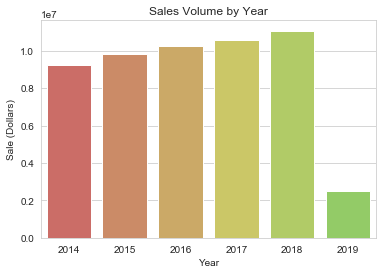

In [264]:
sns.barplot(x ='Year',y='Sale (Dollars)',data=df_year_sales[df_year_sales['Store Number']==2633])
plt.title("Sales Volume by Year");

## CHECKPOINT Combine Liquor Data and Weather for Modeling

In [208]:
with open('chal2_polk_clean.pickle','rb') as read_file:
    polk_clean = pickle.load(read_file)

In [209]:
polk_clean.columns

Index(['Date', 'Store Number', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Gallons)', 'Retail Margin',
       'Gross Margin', 'BRANDIES', 'COCKTAILS', 'COFFEE LIQUEURS', 'GINS',
       'LIQUEURS', 'OTHERS', 'RUM', 'SCHNAPPS', 'SCOTCH', 'TEQUILA', 'VODKA',
       'WHISKIES', 'Year', 'Month', 'Week', 'Day', 'Day_of_week', 'Qtr',
       'PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 'TOBS', 'FLUC', 'DIFF',
       'Daylength', 'Holiday', 'NEXT_TOBS', 'NEXT_PRCP', 'NEXT_SNOW',
       'Daylight_mins'],
      dtype='object')

In [210]:
aggregations = {
     'Pack': 'mean',
     'Bottle Volume (ml)': 'mean',
     'State Bottle Cost': 'mean',
     'State Bottle Retail': 'mean', 
     'Bottles Sold': 'sum',
     'Sale (Dollars)': 'sum', 
     'Volume Sold (Gallons)': 'sum', 
     'Retail Margin': 'mean',
     'Gross Margin': 'mean', 
     'BRANDIES': 'sum', 
     'COCKTAILS': 'sum', 
     'COFFEE LIQUEURS': 'sum', 
     'GINS': 'sum',
     'LIQUEURS': 'sum', 
     'OTHERS': 'sum', 
     'RUM': 'sum', 
     'SCHNAPPS': 'sum', 
     'SCOTCH': 'sum', 
     'TEQUILA': 'sum', 
     'VODKA': 'sum',
     'WHISKIES': 'sum', 
     'PRCP': 'sum',
     'SNOW': 'sum',
     'SNWD': 'sum',
     'TMAX': 'mean',
     'TMIN': 'mean',
     'TOBS': 'mean',
     'FLUC': 'mean',
     'DIFF': 'mean',
     'Holiday': 'sum', 
     'Daylight_mins': 'mean'
}

polk_clean_OLS = polk_clean.groupby(['Year','Qtr','Store Number'], as_index=False).agg(aggregations)

In [359]:
polk_clean_OLS.head()

,Year,Qtr,Store Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Gallons),...,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,FLUC,DIFF,Holiday,Daylight_mins
0,2014,1,2190,765.209302,53916.279070,734.510465,1103.437209,17171,217983.12,3154.50,...,1.88,15.5,82.0,31.209302,8.255814,17.581395,22.953488,1.441860,4,645.116279
1,2014,1,2238,66.000000,6250.000000,65.750000,98.623333,160,2653.34,44.64,...,0.37,0.0,3.0,39.333333,13.666667,21.000000,25.666667,2.000000,0,662.666667
2,2014,1,2248,881.857143,59194.642857,966.581429,1452.374286,6820,126742.58,1431.46,...,1.30,6.7,28.0,34.142857,11.071429,18.357143,23.071429,5.000000,3,640.714286
3,2014,1,2478,215.000000,17125.000000,252.744167,379.222500,2392,40966.77,605.93,...,0.05,1.4,20.0,30.666667,8.000000,21.166667,22.666667,-0.833333,0,645.333333
4,2014,1,2502,1146.142857,106958.928571,1195.480714,1796.393571,14545,194797.55,3992.86,...,0.28,3.6,26.0,30.500000,8.214286,20.500000,22.285714,0.285714,1,647.071429


## Segment out Q1 data and merge with year end sales

In [241]:
polk_clean_OLS_Q1 = polk_clean_OLS[polk_clean_OLS['Qtr']==1]
polk_clean_OLS_Q2 = polk_clean_OLS[polk_clean_OLS['Qtr']==2]

In [242]:
polk_clean_OLS_Q1 = pd.merge(polk_clean_OLS, df_year_sales, how='left', on=['Year','Store Number'])
polk_clean_OLS_Q2 = pd.merge(polk_clean_OLS, df_year_sales, how='left', on=['Year','Store Number'])

In [243]:
del polk_clean_OLS_Q1['Year']
del polk_clean_OLS_Q1['Qtr']
del polk_clean_OLS_Q2['Year']
del polk_clean_OLS_Q2['Qtr']

In [244]:
polk_clean_OLS_Q1.head()

,Store Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars)_x,Volume Sold (Gallons),Retail Margin,Gross Margin,...,SNOW,SNWD,TMAX,TMIN,TOBS,FLUC,DIFF,Holiday,Daylight_mins,Sale (Dollars)_y
0,2190,765.209302,53916.279070,734.510465,1103.437209,17171,217983.12,3154.50,10.485530,2549.400111,...,15.5,82.0,31.209302,8.255814,17.581395,22.953488,1.441860,4,645.116279,1323649.20
1,2238,66.000000,6250.000000,65.750000,98.623333,160,2653.34,44.64,3.000587,442.203500,...,0.0,3.0,39.333333,13.666667,21.000000,25.666667,2.000000,0,662.666667,87382.38
2,2248,881.857143,59194.642857,966.581429,1452.374286,6820,126742.58,1431.46,13.162952,4554.053113,...,6.7,28.0,34.142857,11.071429,18.357143,23.071429,5.000000,3,640.714286,631166.08
3,2478,215.000000,17125.000000,252.744167,379.222500,2392,40966.77,605.93,7.181334,1708.958939,...,1.4,20.0,30.666667,8.000000,21.166667,22.666667,-0.833333,0,645.333333,181014.76
4,2502,1146.142857,106958.928571,1195.480714,1796.393571,14545,194797.55,3992.86,15.724111,7021.538460,...,3.6,26.0,30.500000,8.214286,20.500000,22.285714,0.285714,1,647.071429,1267320.27


In [245]:
polk_clean_OLS_Q1 = polk_clean_OLS_Q1.rename(columns={'Sale (Dollars)_x': 'Qtr_Sales'})
polk_clean_OLS_Q1 = polk_clean_OLS_Q1.rename(columns={'Sale (Dollars)_y': 'EoY_Sales'})
polk_clean_OLS_Q1.columns = polk_clean_OLS_Q1.columns.str.replace(' ','_')

In [344]:
polk_clean_OLS_Q1.head()

,Store_Number,Pack,Bottle_Volume_(ml),State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Qtr_Sales,Volume_Sold_(Gallons),Retail_Margin,Gross_Margin,...,SNOW,SNWD,TMAX,TMIN,TOBS,FLUC,DIFF,Holiday,Daylight_mins,EoY_Sales
0,2190,765.209302,53916.279070,734.510465,1103.437209,17171,217983.12,3154.50,10.485530,2549.400111,...,15.5,82.0,31.209302,8.255814,17.581395,22.953488,1.441860,4,645.116279,1323649.20
1,2238,66.000000,6250.000000,65.750000,98.623333,160,2653.34,44.64,3.000587,442.203500,...,0.0,3.0,39.333333,13.666667,21.000000,25.666667,2.000000,0,662.666667,87382.38
2,2248,881.857143,59194.642857,966.581429,1452.374286,6820,126742.58,1431.46,13.162952,4554.053113,...,6.7,28.0,34.142857,11.071429,18.357143,23.071429,5.000000,3,640.714286,631166.08
3,2478,215.000000,17125.000000,252.744167,379.222500,2392,40966.77,605.93,7.181334,1708.958939,...,1.4,20.0,30.666667,8.000000,21.166667,22.666667,-0.833333,0,645.333333,181014.76
4,2502,1146.142857,106958.928571,1195.480714,1796.393571,14545,194797.55,3992.86,15.724111,7021.538460,...,3.6,26.0,30.500000,8.214286,20.500000,22.285714,0.285714,1,647.071429,1267320.27


In [366]:
corr = polk_clean_OLS_Q1.corr()
corr

,Store_Number,Pack,Bottle_Volume_(ml),State_Bottle_Cost,State_Bottle_Retail,Bottles_Sold,Qtr_Sales,Volume_Sold_(Gallons),Retail_Margin,Gross_Margin,...,SNOW,SNWD,TMAX,TMIN,TOBS,FLUC,DIFF,Holiday,Daylight_mins,EoY_Sales
Store_Number,1.000000,-0.445262,-0.531682,-0.514311,-0.514405,-0.276325,-0.245273,-0.260186,-0.552058,-0.367680,...,-0.118293,-0.080696,0.028858,0.026134,0.026874,0.020859,0.049558,-0.141160,0.010907,-0.246807
Pack,-0.445262,1.000000,0.878323,0.884332,0.884353,0.447820,0.395840,0.412990,0.883869,0.557865,...,0.092000,0.069660,0.004128,0.008714,0.006500,-0.027058,0.010392,0.206791,0.002044,0.393762
Bottle_Volume_(ml),-0.531682,0.878323,1.000000,0.972780,0.972859,0.516490,0.487182,0.515321,0.922767,0.699901,...,0.101838,0.071173,0.011551,0.015306,0.012417,-0.020910,-0.000561,0.205620,0.008785,0.483859
State_Bottle_Cost,-0.514311,0.884332,0.972780,1.000000,0.999999,0.558638,0.534763,0.551467,0.898455,0.726682,...,0.113078,0.082197,0.002732,0.007122,0.004487,-0.026091,0.003632,0.249526,-0.007616,0.527311
State_Bottle_Retail,-0.514405,0.884353,0.972859,0.999999,1.000000,0.558537,0.534659,0.551384,0.898574,0.726613,...,0.113129,0.082155,0.002692,0.007092,0.004453,-0.026154,0.003538,0.249484,-0.007584,0.527216
Bottles_Sold,-0.276325,0.447820,0.516490,0.558638,0.558537,1.000000,0.990166,0.989169,0.502411,0.847645,...,0.191620,0.147584,0.008397,0.009629,0.009358,-0.006157,-0.007572,0.360398,-0.002818,0.968122
Qtr_Sales,-0.245273,0.395840,0.487182,0.534763,0.534659,0.990166,1.000000,0.995780,0.459182,0.850429,...,0.184233,0.141198,0.004909,0.006028,0.005925,-0.006002,-0.008221,0.338073,-0.006613,0.975468
Volume_Sold_(Gallons),-0.260186,0.412990,0.515321,0.551467,0.551384,0.989169,0.995780,1.000000,0.486882,0.872981,...,0.179471,0.136302,0.010424,0.011257,0.011154,-0.003435,-0.008309,0.321714,0.002873,0.975485
Retail_Margin,-0.552058,0.883869,0.922767,0.898455,0.898574,0.502411,0.459182,0.486882,1.000000,0.650459,...,0.153734,0.108968,-0.013833,-0.007566,-0.011198,-0.039954,-0.013805,0.248776,-0.008784,0.455552
Gross_Margin,-0.367680,0.557865,0.699901,0.726682,0.726613,0.847645,0.850429,0.872981,0.650459,1.000000,...,0.126831,0.094261,0.004036,0.006696,0.006263,-0.015441,-0.008134,0.258164,-0.007054,0.824834


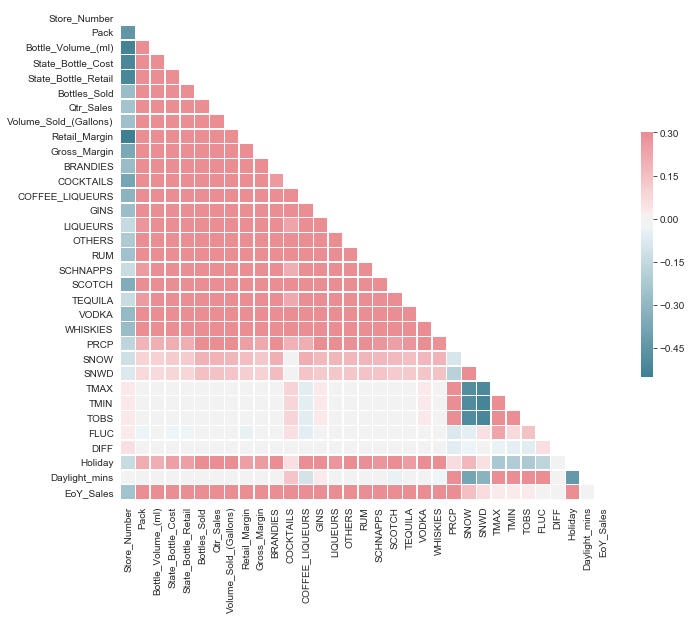

In [365]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

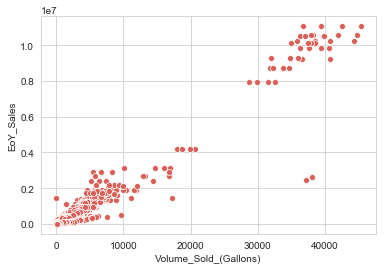

In [345]:
sns.scatterplot(x='Volume_Sold_(Gallons)', y="EoY_Sales", data=polk_clean_OLS_Q1)

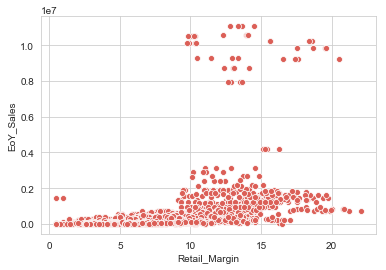

In [346]:
sns.scatterplot(x='Retail_Margin', y="EoY_Sales", data=polk_clean_OLS_Q1)

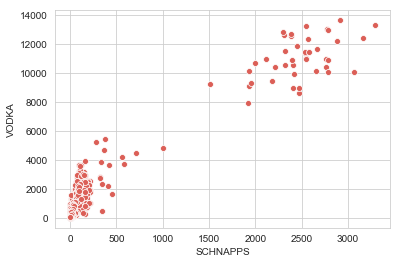

In [371]:
sns.scatterplot(x='SCHNAPPS', y="VODKA", data=polk_clean_OLS_Q1)

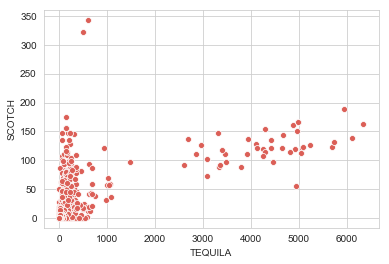

In [373]:
sns.scatterplot(x='TEQUILA', y="SCOTCH", data=polk_clean_OLS_Q1)

In [247]:
polk_clean_OLS_Q1.columns

Index(['Store_Number', 'Pack', 'Bottle_Volume_(ml)', 'State_Bottle_Cost',
       'State_Bottle_Retail', 'Bottles_Sold', 'Qtr_Sales',
       'Volume_Sold_(Gallons)', 'Retail_Margin', 'Gross_Margin', 'BRANDIES',
       'COCKTAILS', 'COFFEE_LIQUEURS', 'GINS', 'LIQUEURS', 'OTHERS', 'RUM',
       'SCHNAPPS', 'SCOTCH', 'TEQUILA', 'VODKA', 'WHISKIES', 'PRCP', 'SNOW',
       'SNWD', 'TMAX', 'TMIN', 'TOBS', 'FLUC', 'DIFF', 'Holiday',
       'Daylight_mins', 'EoY_Sales'],
      dtype='object')

In [248]:
#Create 2 dataframes for modeling, one for Q1 and one for Q2
polk_clean_OLS_Q2 = polk_clean_OLS_Q2.rename(columns={'Sale (Dollars)_x': 'Qtr_Sales'})
polk_clean_OLS_Q2 = polk_clean_OLS_Q2.rename(columns={'Sale (Dollars)_y': 'EoY_Sales'})
polk_clean_OLS_Q2.columns = polk_clean_OLS_Q2.columns.str.replace(' ','_')

In [256]:
#Pickle the combined dataframe as polk_clean_OLS for modeling
with open('chal2_polk_clean_OLS.pickle', 'wb') as to_write:
    pickle.dump(polk_clean_OLS_Q1, to_write)

In [257]:
#Pickle the combined dataframe as polk_clean_OLS for modeling
with open('chal2_polk_clean_OLS_Q2.pickle', 'wb') as to_write:
    pickle.dump(polk_clean_OLS_Q2, to_write)

## Supplemental Material and Charts

In [333]:
Scotch_df_Q2 = polk_clean_OLS_Q2.drop(['Store_Number', 'Pack', 'Bottle_Volume_(ml)', 'State_Bottle_Cost',
       'State_Bottle_Retail', 'Bottles_Sold',
       'Volume_Sold_(Gallons)'],axis=1, errors="ignore")

In [334]:
corr_scotch_Q2 = Scotch_df_Q2.corr()

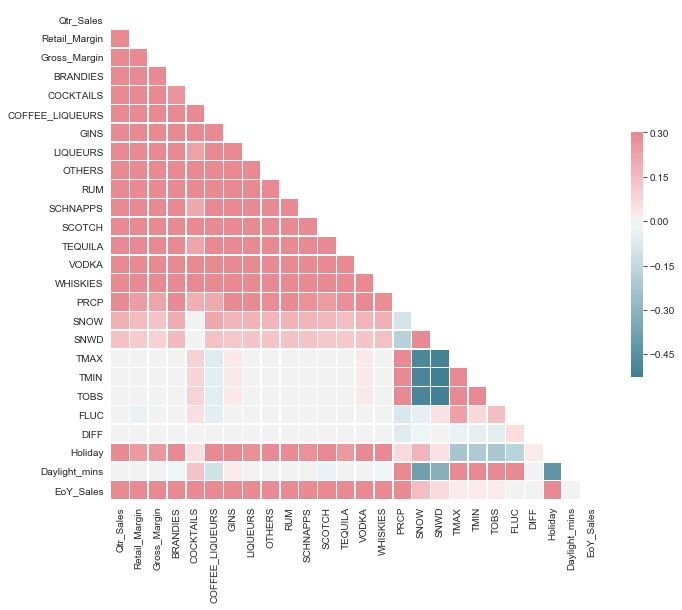

In [335]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_scotch_Q2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_scotch_Q2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [163]:
margin_by_liquor = pd.DataFrame(polk_OLS.groupby(polk_OLS['Liquor Type'], as_index=False)['Retail Margin'].mean())
margin_by_liquor.sort_values(by='Retail Margin', ascending=False, inplace=True)
margin_by_liquor.head()

,Liquor Type,Retail Margin
1,COCKTAILS,0.506317
2,COFFEE LIQUEURS,0.502848
6,RUM,0.502450
7,SCHNAPPS,0.502429
10,VODKA,0.502371


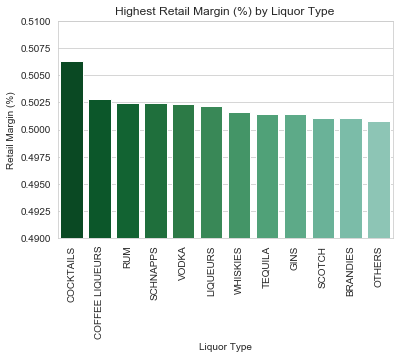

In [269]:
sns.set_palette("BuGn_r", n_colors=20)
sns.barplot(x ='Liquor Type',y='Retail Margin',data=margin_by_liquor)
plt.title("Highest Retail Margin (%) by Liquor Type")
plt.ylim(0.49, .51)
plt.ylabel("Retail Margin (%)")
plt.xticks(rotation=90);

In [165]:
gross_by_liquor = pd.DataFrame(polk_OLS.groupby(polk_OLS['Liquor Type'], as_index=False)['Gross Margin'].mean())
gross_by_liquor.sort_values(by='Gross Margin', ascending=False, inplace=True)
gross_by_liquor.head()

,Liquor Type,Gross Margin
9,TEQUILA,351.767248
10,VODKA,339.769336
8,SCOTCH,264.067451
11,WHISKIES,262.714964
4,LIQUEURS,215.185374


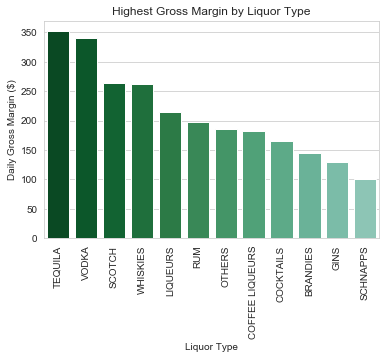

In [166]:
sns.barplot(x ='Liquor Type',y='Gross Margin',data=gross_by_liquor)
plt.title("Highest Gross Margin by Liquor Type")
plt.ylabel("Daily Gross Margin ($)")
plt.xticks(rotation=90);

In [258]:
polk_clean_graph = polk_daily_clean.copy()
polk_clean_graph['Month'] = polk_clean_graph['Date'].dt.strftime('%b')
vol_by_month = pd.DataFrame(polk_clean_graph.groupby(['Month'], as_index=False)['Volume Sold (Gallons)'].agg(np.mean))

In [259]:
month = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug', 'Sep','Oct','Nov','Dec']
msorterIndex = dict(zip(month,range(len(month))))
msorterIndex

{'Jan': 0,
 'Feb': 1,
 'Mar': 2,
 'Apr': 3,
 'May': 4,
 'Jun': 5,
 'Jul': 6,
 'Aug': 7,
 'Sep': 8,
 'Oct': 9,
 'Nov': 10,
 'Dec': 11}

In [260]:
vol_by_month['Month_id'] = vol_by_month['Month']
vol_by_month['Month_id'] = vol_by_month['Month_id'].map(msorterIndex)
vol_by_month.sort_values('Month_id', inplace=True)
vol_by_month.head(12)

,Month,Volume Sold (Gallons),Month_id
4,Jan,102.550728,0
3,Feb,118.551423,1
7,Mar,114.854856,2
0,Apr,130.489093,3
8,May,126.352893,4
6,Jun,130.414195,5
5,Jul,117.964454,6
1,Aug,116.705150,7
11,Sep,119.610936,8
10,Oct,135.189631,9


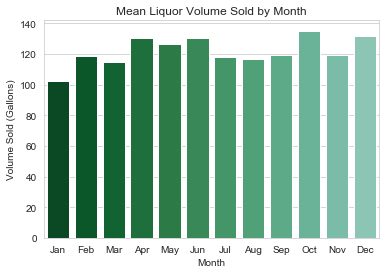

In [261]:
sns.barplot(x ='Month',y='Volume Sold (Gallons)',data=vol_by_month)
plt.title("Mean Liquor Volume Sold by Month");

In [262]:
sorter = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
sorterIndex = dict(zip(range(len(sorter)),sorter))
sorterIndex

{0: 'Monday',
 1: 'Tuesday',
 2: 'Wednesday',
 3: 'Thursday',
 4: 'Friday',
 5: 'Saturday'}

In [317]:
vol_by_weekday = pd.DataFrame(polk_daily_clean.groupby(['Day_of_week'],as_index=False)
                              ['Volume Sold (Gallons)'].agg(np.mean))

In [319]:
vol_by_weekday['Day_id'] = vol_by_weekday['Day_of_week']
vol_by_weekday['Day_id'] = vol_by_weekday['Day_id'].map(sorterIndex)
vol_by_weekday.sort_values('Day_of_week', inplace=True)
vol_by_weekday.head(6)

,Day_of_week,Volume Sold (Gallons),Day_id
0,0,155.609985,Monday
1,1,101.794756,Tuesday
2,2,93.757424,Wednesday
3,3,133.882131,Thursday
4,4,102.687252,Friday
5,5,143.545845,Saturday


Text(0.5, 0, 'Days of the Week')

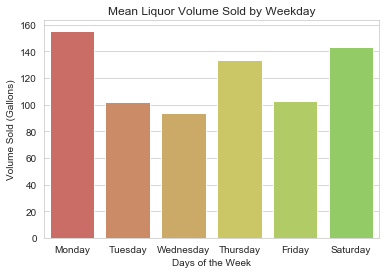

In [320]:
sns.barplot(x ='Day_id',y='Volume Sold (Gallons)',data=vol_by_weekday)
plt.title("Mean Liquor Volume Sold by Weekday")
plt.xlabel("Days of the Week")

In [271]:
vol_by_week = pd.DataFrame(polk_clean_graph.groupby(['Week'],as_index=False)
                              ['Volume Sold (Gallons)'].agg(np.mean))

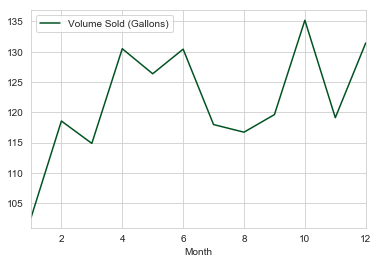

In [272]:
# pivot table of average sales with rows=month and cols as promotion or not
polk_clean.pivot_table(index='Month', values='Volume Sold (Gallons)').plot();

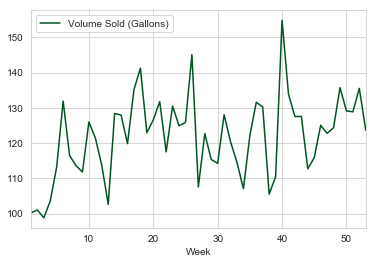

In [273]:
polk_clean.pivot_table(index='Week', values='Volume Sold (Gallons)').plot();

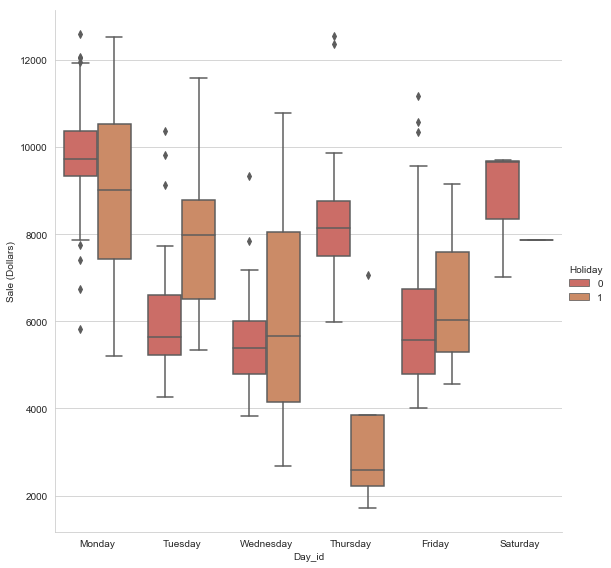

In [323]:
# does day of week affect volume of sales, closed on Sundays
sns.set_palette("hls", n_colors=20)
df_day_of_week = pd.DataFrame(polk_daily_clean.groupby(['Week', 'Day_of_week', 'Holiday'], as_index=False)['Sale (Dollars)'].mean())
df_day_of_week['Day_id'] = df_day_of_week['Day_of_week']
df_day_of_week['Day_id'] = df_day_of_week['Day_id'].map(sorterIndex)
sns.set
sns.catplot(
    hue='Holiday',
    x='Day_id',
    y='Sale (Dollars)',
    data=df_day_of_week,
    kind='box',
    height=8);


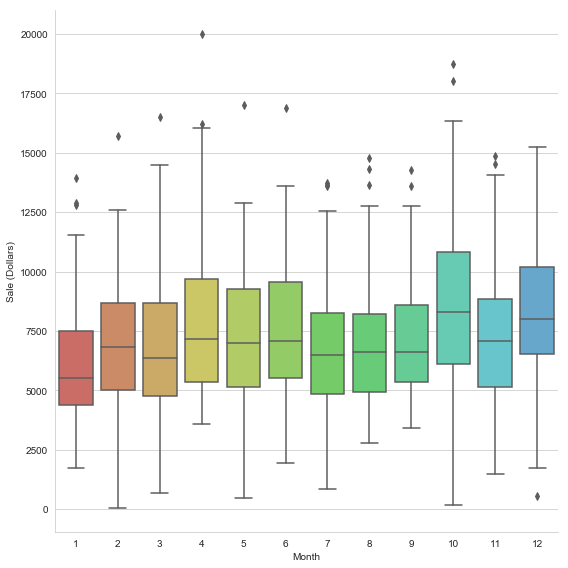

In [315]:
df_month = pd.DataFrame(polk_daily_clean.groupby(['Month', 'Date'], as_index=False)['Sale (Dollars)'].mean())
sns.catplot(
    x='Month',
    y='Sale (Dollars)',
    data=df_month,
    kind='box',
    height=8);

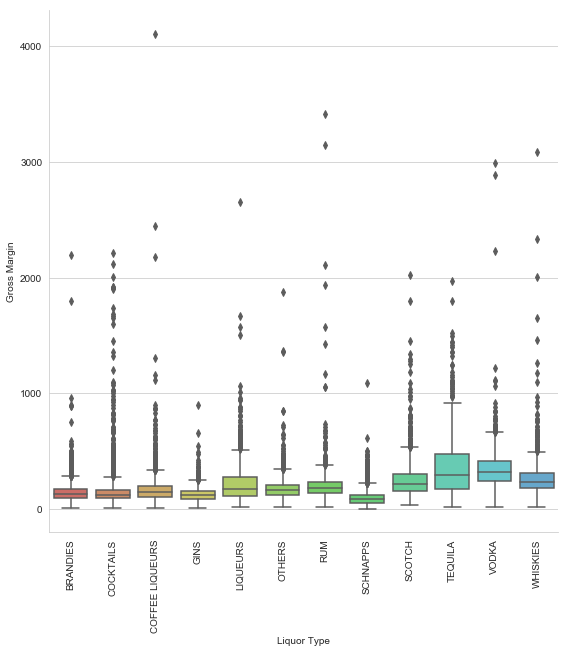

In [329]:
df_liquor_type = pd.DataFrame(polk_OLS.groupby(['Liquor Type', 'Date'], as_index=False)['Gross Margin'].mean())
sns.catplot(
    x='Liquor Type',
    y='Gross Margin',
    data=df_liquor_type,
    kind='box',
    height=8);
plt.xticks(rotation=90);

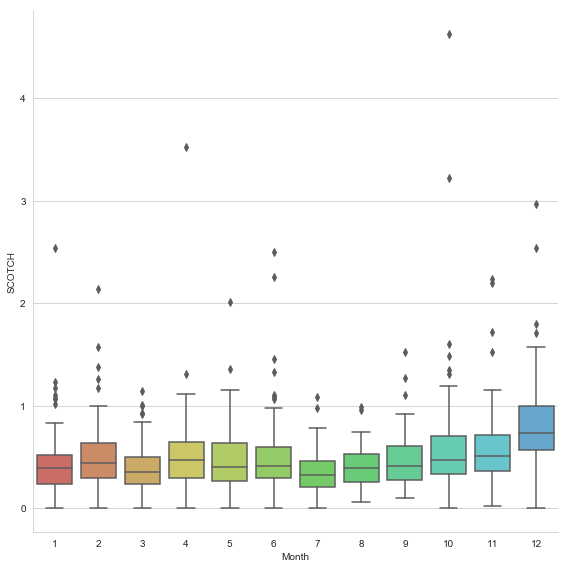

In [296]:
df_scotch = pd.DataFrame(polk_daily_OLS.groupby(['Month', 'Date'], as_index=False)['SCOTCH'].mean())
sns.catplot(
    x='Month',
    y='SCOTCH',
    data=df_scotch,
    kind='box',
    height=8);

Text(9.550000000000004, 0.5, 'Tequila Bottles Per Day')

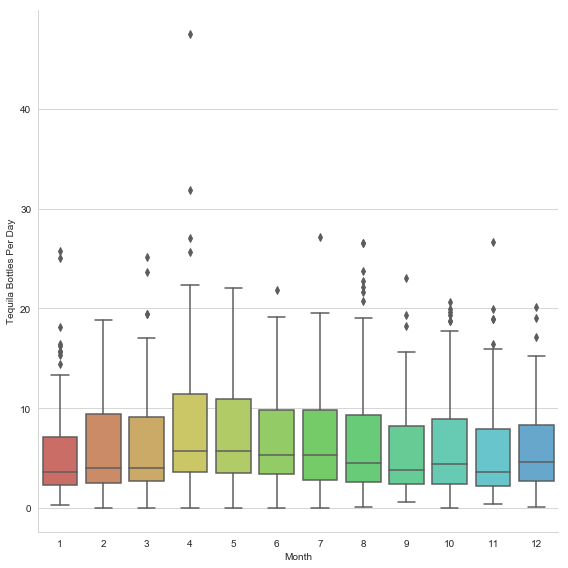

In [302]:
df_tequila = pd.DataFrame(polk_daily_OLS.groupby(['Month', 'Date'], as_index=False)['TEQUILA'].mean())
sns.catplot(
    x='Month',
    y='TEQUILA',
    data=df_tequila,
    kind='box',
    height=8);
plt.ylabel("Tequila Bottles Per Day")

Text(3.9250000000000043, 0.5, 'Whiskies Bottles Per Day')

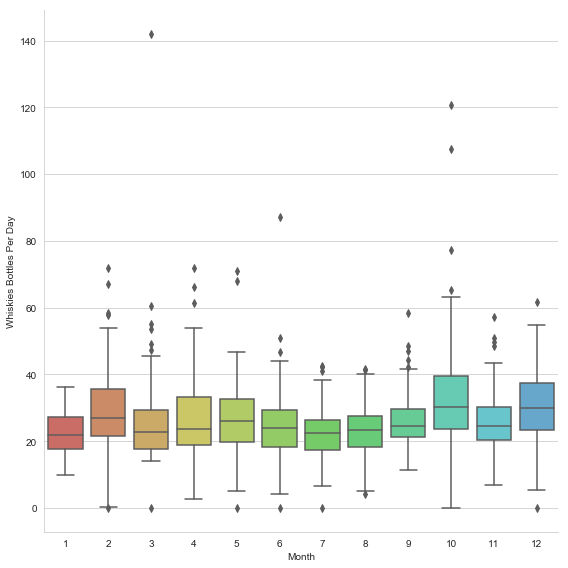

In [375]:
df_whiskies = pd.DataFrame(polk_daily_OLS.groupby(['Month', 'Date'], as_index=False)['WHISKIES'].mean())
sns.catplot(
    x='Month',
    y='WHISKIES',
    data=df_whiskies,
    kind='box',
    height=8);
plt.ylabel("Whiskies Bottles Per Day")

Text(3.9250000000000043, 0.5, 'Vodka Bottles Per Day')

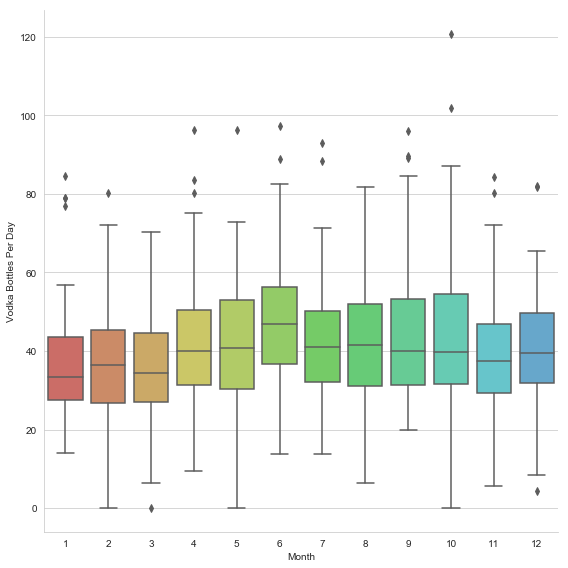

In [376]:
df_vodka = pd.DataFrame(polk_daily_OLS.groupby(['Month', 'Date'], as_index=False)['VODKA'].mean())
sns.catplot(
    x='Month',
    y='VODKA',
    data=df_vodka,
    kind='box',
    height=8);
plt.ylabel("Vodka Bottles Per Day")

/Users/robfang29/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


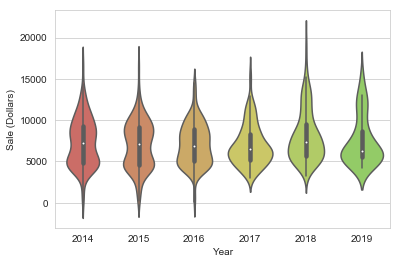

In [278]:
df_year = pd.DataFrame(polk_daily_OLS.groupby(['Year', 'Date'], as_index=False)['Sale (Dollars)'].mean())
sns.violinplot(x=df_year['Year'], y=df_year['Sale (Dollars)'])
plt.xlabel("Year")
plt.ylabel("Sale (Dollars)");

## Time Series Practice

In [279]:
liquor_type_df = liquor_polk.copy()

In [280]:
liquor_type_df["Month"] = liquor_type_df.Date.dt.month
liquor_type_df["Week"] = liquor_type_df.Date.dt.week
liquor_type_df["Day"] = liquor_type_df.Date.dt.day
liquor_type_df["Day_of_week"] = liquor_type_df.Date.dt.weekday

In [281]:
df = pd.DataFrame(polk_clean.groupby(['Date'])['Volume Sold (Gallons)'].mean())
weekly_average_sales = df['Volume Sold (Gallons)'].resample('W').mean()

(-0.25, 0.5)

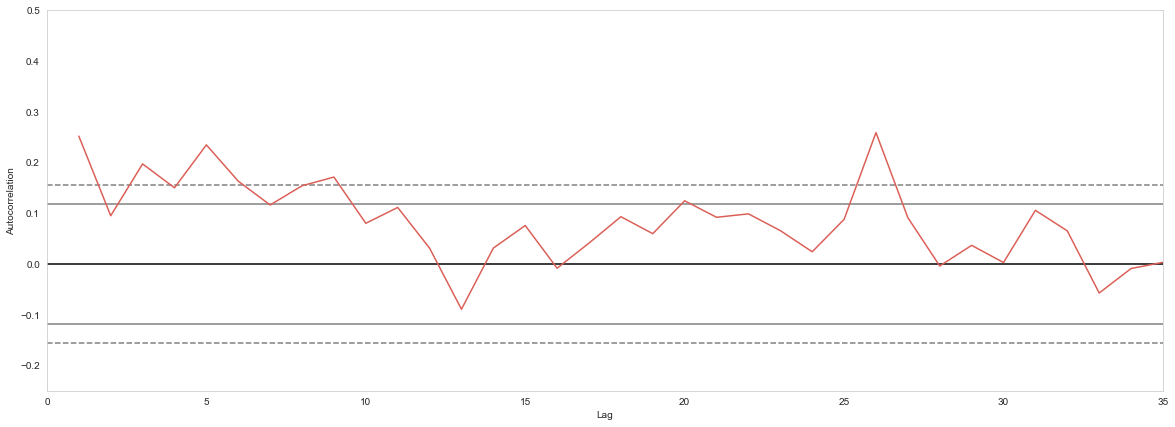

In [282]:
from pandas.plotting import autocorrelation_plot
plt.figure(figsize=(20,7))

autocorrelation_plot(weekly_average_sales)
plt.xlim(0,35);
plt.ylim(-.25,.5)

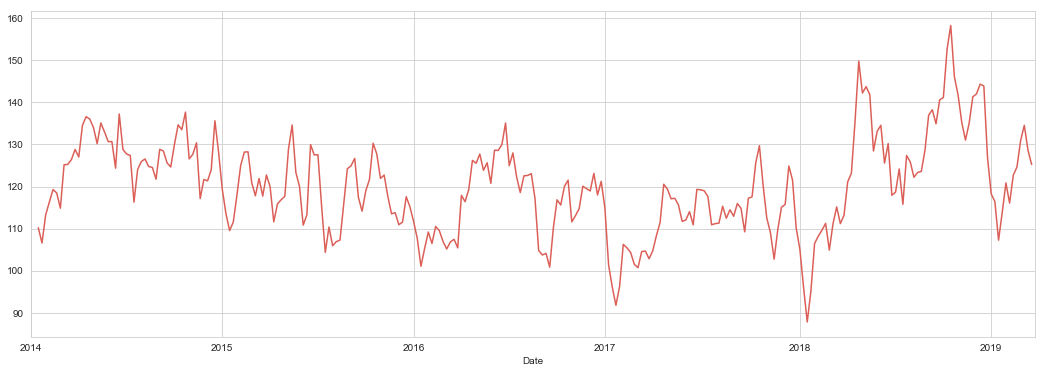

In [283]:
weekly_average_sales.rolling(window=4, center=True).mean().plot(figsize=(18,6));

In [284]:
monthly_average_sales = df['Volume Sold (Gallons)'].resample('M').mean()

(-0.5, 0.5)

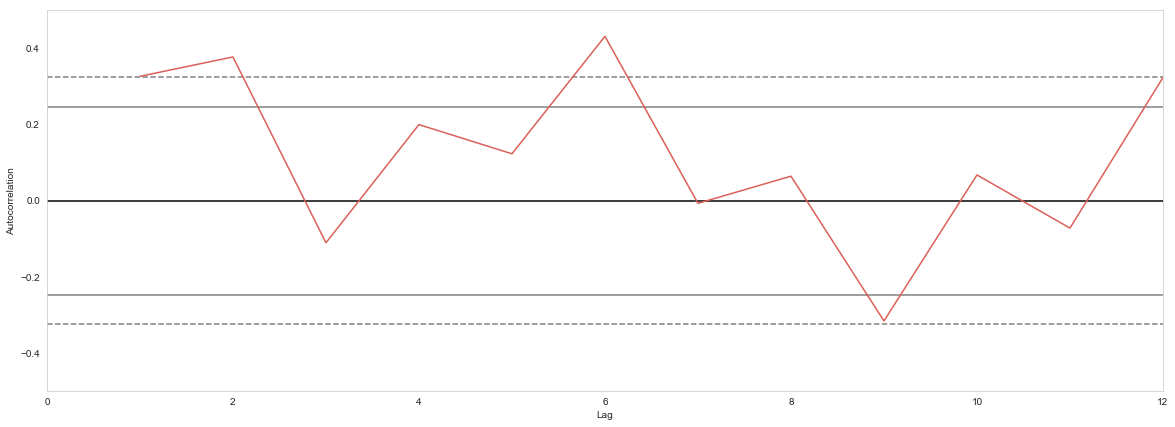

In [285]:
plt.figure(figsize=(20,7))
autocorrelation_plot(monthly_average_sales)
plt.xlim(0,12);
plt.ylim(-.5,.5)

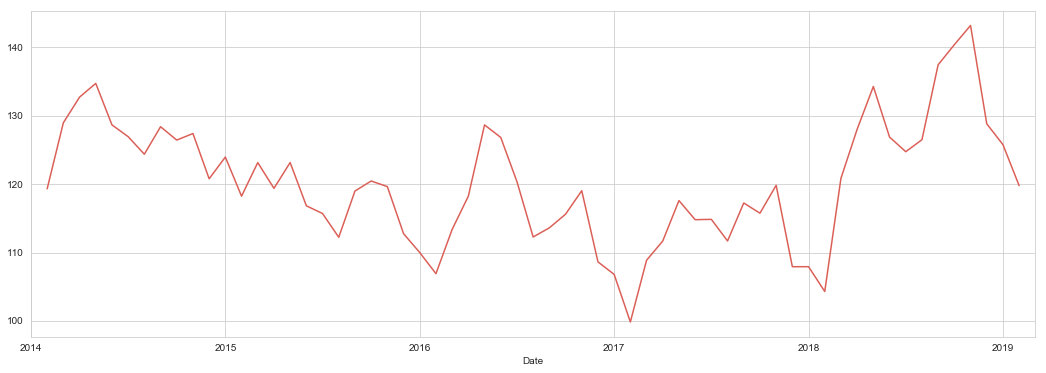

In [286]:
monthly_average_sales.rolling(window=3, center=True).mean().plot(figsize=(18,6));

In [94]:
df_bubble = liquor_polk.copy()

In [95]:
df_bubble['Week']=df_bubble['Date'].dt.week
df_bubble['Week']=df_bubble['Date'].dt.week

In [96]:
df_bubble.columns

Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Address',
       'City', 'Zip Code', 'Store Location', 'County Number', 'County',
       'Category', 'Category Name', 'Vendor Number', 'Vendor Name',
       'Item Number', 'Item Description', 'Pack', 'Bottle Volume (ml)',
       'State Bottle Cost', 'State Bottle Retail', 'Bottles Sold',
       'Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)',
       'Liquor Type', 'Week'],
      dtype='object')

In [97]:
df_bubble = df_bubble.groupby(['Category Name'], as_index = False).agg({'Volume Sold (Gallons)':'sum','State Bottle Retail': 'mean'})

In [98]:
df_bubble.to_excel("bubble_graph.xlsx")

In [89]:
x=df_bubble['Item Description']
y=df_bubble['Sale (Dollars)']
z=df_bubble['State Bottle Retail']